In [1]:
import numpy as np

In [2]:
data = open("C:/Users/Li Yuxin/DSA4212/Assignment 3/HP1_paragraph.txt").read().lower()

In [3]:
words = data.split()
len(words)

273

In [4]:
split_index = int(0.8 * len(words))

train_data = words[:split_index]
test_data = words[split_index:]

In [5]:
len(set(train_data)-set(test_data))

120

In [6]:
len(set(test_data)-set(train_data))

24

In [7]:
word_set = set(words)
word_to_idx = {w:i for i, w in enumerate(word_set)}
idx_to_word = {i:w for i, w in enumerate(word_set)}

In [8]:
word_size = len(word_set)

In [9]:
def oneHotEncode(text):
    output = np.zeros((word_size, 1))
    output[word_to_idx[text]] = 1

    return output

# Xavier Normalized Initialization
def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))

##### Activation Functions #####
def sigmoid(input, derivative = False):
    if derivative:
        return input * (1 - input)
    
    return 1 / (1 + np.exp(-input))

def tanh(input, derivative = False):
    if derivative:
        return 1 - input ** 2
    
    return np.tanh(input)

def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))

##### Long Short-Term Memory Network Class #####
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, num_epochs, learning_rate):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        # Forget Gate
        self.wf = initWeights(input_size, hidden_size)
        self.bf = np.zeros((hidden_size, 1))

        # Input Gate
        self.wi = initWeights(input_size, hidden_size)
        self.bi = np.zeros((hidden_size, 1))

        # Candidate Gate
        self.wc = initWeights(input_size, hidden_size)
        self.bc = np.zeros((hidden_size, 1))

        # Output Gate
        self.wo = initWeights(input_size, hidden_size)
        self.bo = np.zeros((hidden_size, 1))

        # Final Gate
        self.wy = initWeights(hidden_size, output_size)
        self.by = np.zeros((output_size, 1))

    # Reset Network Memory
    def reset(self):
        self.concat_inputs = {}

        self.hidden_states = {-1:np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1:np.zeros((self.hidden_size, 1))}

        self.activation_outputs = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    # Forward Propogation
    def forward(self, inputs):
        self.reset()

        outputs = []
        for q in range(len(inputs)):
            self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], inputs[q]))

            self.forget_gates[q] = sigmoid(np.dot(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(np.dot(self.wi, self.concat_inputs[q]) + self.bi)
            self.candidate_gates[q] = tanh(np.dot(self.wc, self.concat_inputs[q]) + self.bc)
            self.output_gates[q] = sigmoid(np.dot(self.wo, self.concat_inputs[q]) + self.bo)

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.candidate_gates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            outputs += [np.dot(self.wy, self.hidden_states[q]) + self.by]

        return outputs

    # Backward Propogation
    def backward(self, errors, inputs):
        d_wf, d_bf = 0, 0
        d_wi, d_bi = 0, 0
        d_wc, d_bc = 0, 0
        d_wo, d_bo = 0, 0
        d_wy, d_by = 0, 0

        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])
        for q in reversed(range(len(inputs))):
            error = errors[q]

            # Final Gate Weights and Biases Errors
            d_wy += np.dot(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = np.dot(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs * sigmoid(self.output_gates[q], derivative = True)
            d_wo += np.dot(d_o, inputs[q].T)
            d_bo += d_o

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1] * sigmoid(self.forget_gates[q], derivative = True)
            d_wf += np.dot(d_f, inputs[q].T)
            d_bf += d_f

            # Input Gate Weights and Biases Errors
            d_i = d_cs * self.candidate_gates[q] * sigmoid(self.input_gates[q], derivative = True)
            d_wi += np.dot(d_i, inputs[q].T)
            d_bi += d_i
            
            # Candidate Gate Weights and Biases Errors
            d_c = d_cs * self.input_gates[q] * tanh(self.candidate_gates[q], derivative = True)
            d_wc += np.dot(d_c, inputs[q].T)
            d_bc += d_c

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = np.dot(self.wf.T, d_f) + np.dot(self.wi.T, d_i) + np.dot(self.wc.T, d_c) + np.dot(self.wo.T, d_o)

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        for d_ in (d_wf, d_bf, d_wi, d_bi, d_wc, d_bc, d_wo, d_bo, d_wy, d_by):
            np.clip(d_, -1, 1, out = d_)

        self.wf += d_wf * self.learning_rate
        self.bf += d_bf * self.learning_rate

        self.wi += d_wi * self.learning_rate
        self.bi += d_bi * self.learning_rate

        self.wc += d_wc * self.learning_rate
        self.bc += d_bc * self.learning_rate

        self.wo += d_wo * self.learning_rate
        self.bo += d_bo * self.learning_rate

        self.wy += d_wy * self.learning_rate
        self.by += d_by * self.learning_rate

    # Train
    def train(self, inputs, labels):
        inputs = [oneHotEncode(input) for input in inputs]
        loss_sum = []
        loss_mean = []
        accuracies = []

        for _ in range(self.num_epochs):
            predictions = self.forward(inputs)

            errors = []
            accuracy = 0
            for q in range(len(predictions)):
                errors += [-softmax(predictions[q])]
                errors[-1][word_to_idx[labels[q]]] += 1
                prediction = str(idx_to_word[np.random.choice([*range(word_size)], p = softmax(predictions[q].reshape(-1)))])
                
                if prediction == labels[q]:
                    accuracy += 1

            loss_sum.append(np.sum([e**2 for e in errors]))
            loss_mean.append(np.mean([e**2 for e in errors]))
            accuracies.append((accuracy/len(labels))*100)
            
            if (_ == 0) | ((_+1)%20==0):
                print(f"Epoch: {_+1}, Loss (sum): {loss_sum[_]}, Loss (mean): {loss_mean[_]}, Accuracy: {accuracies[_]} \n")
                
            self.backward(errors, self.concat_inputs)
            
        return loss_sum, loss_mean, accuracies
    
    # Test
    def test(self, inputs, labels):
        accuracy = 0
        predictions = self.forward([oneHotEncode(input) for input in inputs])

        output = []
        for q in range(len(labels)):
            prediction = str(idx_to_word[np.random.choice([*range(word_size)], p = softmax(predictions[q].reshape(-1)))])

            output.append(prediction)

            if prediction == labels[q]:
                accuracy += 1

        print(f'Ground Truth:\nt{labels}\n')
        print(f'Predictions:\nt{output}\n')
        
        print(f'Accuracy: {round(accuracy * 100 / len(labels), 2)}%')

In [10]:
# Initialize Network
hidden_size = 25
lstm = LSTM(input_size = word_size + hidden_size, hidden_size = hidden_size, output_size = word_size, num_epochs = 500, learning_rate = 0.05)

##### Training #####
train_X, train_y = train_data[:-1], train_data[1:]
train_loss_sum, train_loss_mean, train_accuracy = lstm.train(train_X, train_y)

Epoch: 1, Loss (sum): 215.67931386745488, Loss (mean): 0.006060450541403138, Accuracy: 0.0 

Epoch: 20, Loss (sum): 214.02613877911924, Loss (mean): 0.006013997380552974, Accuracy: 0.4608294930875576 

Epoch: 40, Loss (sum): 210.43474141955306, Loss (mean): 0.005913081415633165, Accuracy: 4.147465437788019 

Epoch: 60, Loss (sum): 179.31854160072095, Loss (mean): 0.005038736135796362, Accuracy: 11.981566820276496 

Epoch: 80, Loss (sum): 99.82795158843606, Loss (mean): 0.0028051014833212337, Accuracy: 37.78801843317972 

Epoch: 100, Loss (sum): 37.498229147852875, Loss (mean): 0.0010536762152369584, Accuracy: 62.67281105990783 

Epoch: 120, Loss (sum): 11.776519969648438, Loss (mean): 0.0003309126663383286, Accuracy: 78.80184331797236 

Epoch: 140, Loss (sum): 4.269765821285891, Loss (mean): 0.00011997768408693637, Accuracy: 91.24423963133641 

Epoch: 160, Loss (sum): 1.718626507385474, Loss (mean): 4.8292303793005344e-05, Accuracy: 91.70506912442397 

Epoch: 180, Loss (sum): 0.8660333

In [11]:
lstm.test(train_data[:-1], train_data[1:])

Ground Truth:
t['potter', 'and', 'the', "sorcerer's", 'stone', 'chapter', 'one', 'the', 'boy', 'who', 'lived', 'mr.', 'and', 'mrs.', 'dursley,', 'of', 'number', 'four,', 'privet', 'drive,', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal,', 'thank', 'you', 'very', 'much.', 'they', 'were', 'the', 'last', 'people', "you'd", 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious,', 'because', 'they', 'just', "didn't", 'hold', 'with', 'such', 'nonsense.', 'mr.', 'dursley', 'was', 'the', 'director', 'of', 'a', 'firm', 'called', 'grunnings,', 'which', 'made', 'drills.', 'he', 'was', 'a', 'big,', 'beefy', 'man', 'with', 'hardly', 'any', 'neck,', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache.', 'mrs.', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck,', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning'

In [12]:
test_X, test_y = test_data[:-1], test_data[1:]
lstm.test(test_X, test_y)

Ground Truth:
t['shuddered', 'to', 'think', 'what', 'the', 'neighbors', 'would', 'say', 'if', 'the', 'potters', 'arrived', 'in', 'the', 'street.', 'the', 'dursleys', 'knew', 'that', 'the', 'potters', 'had', 'a', 'small', 'son,', 'too,', 'but', 'they', 'had', 'never', 'even', 'seen', 'him.', 'this', 'boy', 'was', 'another', 'good', 'reason', 'for', 'keeping', 'the', 'potters', 'away;', 'they', "didn't", 'want', 'dudley', 'mixing', 'with', 'a', 'child', 'like', 'that.']

Predictions:
t['had', 'everything', 'years;', 'they', 'a', 'mrs.', 'mrs.', 'as', 'was', 'man', 'who', 'much', 'a', 'a', 'strange', 'mrs.', 'dursleys', 'had', 'of', 'a', 'boy', 'had', 'a', 'firm', 'son', 'mrs.', 'or', 'she', "didn't", 'a', 'with', 'man', 'such', 'any', 'nonsense.', 'dursley', 'the', 'was', 'to', 'to', 'a', 'her', 'man', 'mrs.', 'dursley', "didn't", 'have', 'have', 'a', 'a', 'four,', 'dudley', 'twice', 'he']

Accuracy: 7.41%


Text(0, 0.5, 'training loss')

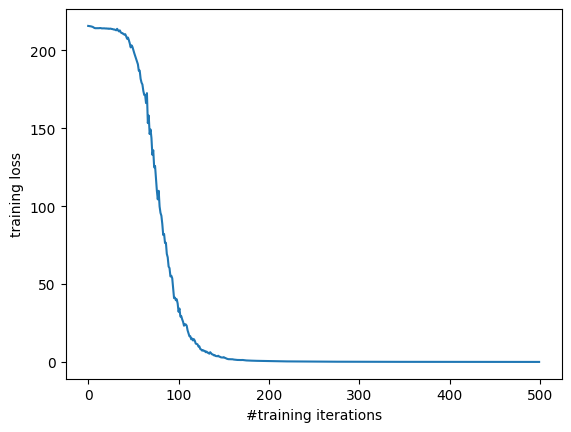

In [13]:
import pylab as plt

plt.plot([i for i in range(len(train_loss_sum))], train_loss_sum)
plt.xlabel("#training iterations")
plt.ylabel("training loss")

Text(0, 0.5, 'mean training loss')

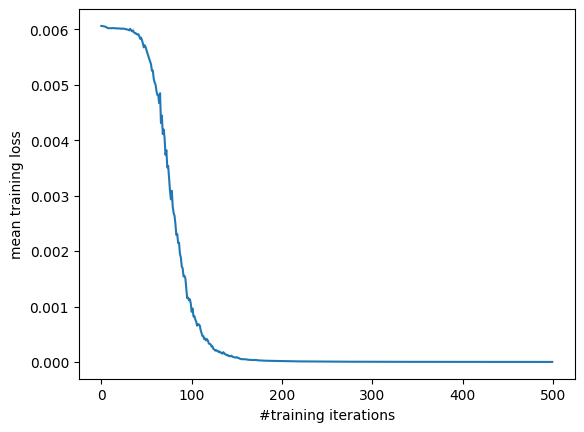

In [15]:
plt.plot([i for i in range(len(train_loss_mean))], train_loss_mean)
plt.xlabel("#training iterations")
plt.ylabel("mean training loss")

In [16]:
import random
train_data_shuffled = np.copy(train_data)
random.shuffle(train_data_shuffled)

lstm.test(train_data_shuffled[:-1], train_data_shuffled[1:])

Ground Truth:
t['but' 'discover' 'have' 'they' 'mrs.' 'in' 'years;' 'they' 'be.' 'but'
 'the' 'was' 'to' 'much' 'fences,' 'because' 'in' 'came' 'a' 'made'
 'nearly' 'neighbors.' 'she' 'it' 'fear' 'mrs.' 'very' 'was' 'fact,' 'and'
 "didn't" 'who' 'they' 'mrs.' 'a' 'potter' 'a' 'about' 'of' 'and'
 "dursley's" 'dudley' 'dursley' 'good-for-nothing' 'opinion' 'it.' 'the'
 'to' 'with' 'the' 'there' 'much.' 'called' 'it' 'think' 'anyone' 'called'
 'which' 'everything' 'somebody' 'did' 'dursley,' 'mr.' 'they' 'to'
 'sister,' 'mustache.' 'in' 'the' 'the' 'very' 'mysterious,' 'lived'
 'neck,' 'a' 'mrs.' 'or' 'privet' 'boy' 'harry' 'sister,' 'was' 'thank'
 'mr.' 'boy' 'met' 'and' 'thin' 'had' 'be' 'son' 'the' 'beefy' 'say'
 'with' 'potter' 'was' 'small' 'grunnings,' 'for' 'was' 'he' 'such' 'was'
 'normal,' 'bear' 'were' 'were' 'the' "hadn't" 'the' 'twice' 'drills.'
 'man' 'drive,' 'garden' 'as' 'her' 'were' 'anywhere.' 'as' 'that'
 'number' 'because' 'people' 'perfectly' 'he' 'their' 'that' 'secr